# Protocolo de Teletransportación Cuántica

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UGate
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.result import marginal_distribution
from qiskit.result import marginal_counts
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

In [2]:
def crear_estado_de_bell (circuito, q0, q1, bell):
  circuito.h(q0)
  circuito.cx(q0,q1)
  match bell:
    case "10":
      circuito.x(q1)
    case "01":
      circuito.z(q1)
    case "11":
      circuito.x(q1)
      circuito.z(q0)
    case "00":
      pass

In [3]:
def alice_operaciones(circuito, q0, q1, bit0, bit1):
    circuito.cx(q0, q1)
    circuito.h(q0)
    circuito.measure(q0, bit0)
    circuito.measure(q1, bit1)

In [4]:
def bob_operaciones(circuito, q2, bit0, bit1, bell):
    #Esta función aplica X-gate, Z-gate, ambos o ninguno sobre el qubit de Bob en función del estado de bell utilizado. 
    #(recordar que el orden de los bits medidos y la notación de los estados de bell son opuestas).
    with circuito.if_test((bit1, not int(bell[0]))):
        circuito.x(q2)
    with circuito.if_test((bit0, not int(bell[1]))):
        circuito.z(q2)

In [5]:
def teleportation(U_init_gate, bell_state="00"):
    # Se definen 3 qúbits
    qubits = QuantumRegister(3, name="q")
    
    # Se definen 2 registros clásicos
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    result = ClassicalRegister(1, name="Resultado")

    # Se construye el objeto circuito
    circuito = QuantumCircuit(qubits, bit0, bit1, result)

    # Se inicializa el qúbit de Alice:
    circuito.append(U_init_gate, [0])

    #Se crea un par de qubits en un estado tipo Bell
    crear_estado_de_bell(circuito, qubits[1], qubits[2], bell_state)
    circuito.barrier()

    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits[0], qubits[1], bit0, bit1)
    circuito.barrier()

    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits[2], bit0, bit1, bell_state)
    
    circuito.barrier()
    #circuito.append(U_init_gate.inverse(), [2])
    circuito.measure(qubits[2], result)
    
    return [circuito, qubits]

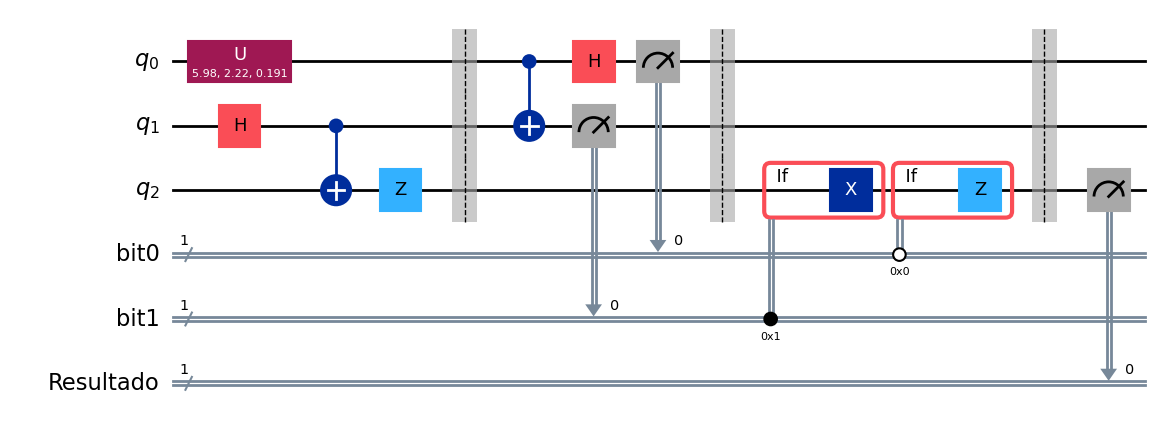

In [6]:
#Definimos la operación unitaria que prepara el estado que se desea teletransportar
random_gate = UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi
)

#Ejecutamos el algoritmo de teleportación en el estado Bell 10
qc, qubits = teleportation(random_gate, bell_state="01")

#Dibujamos el circuito resultante
qc.draw(output="mpl")

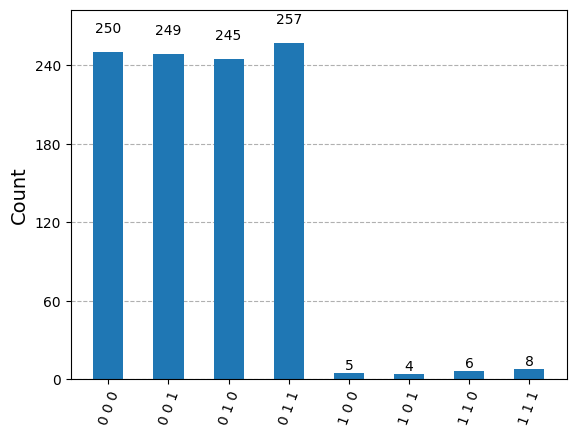

In [7]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

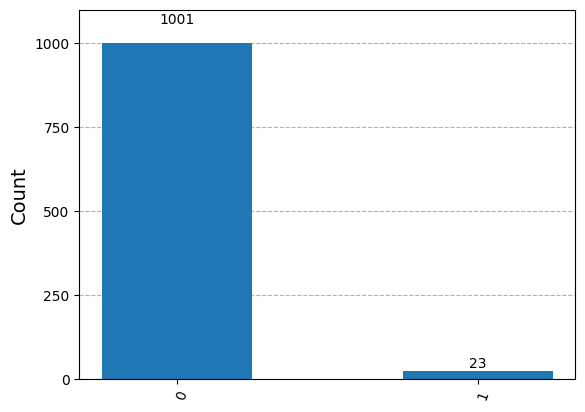

In [8]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

In [9]:
ket0 = Statevector([1,0])
ket1 = Statevector([0,1])

psi = ket0.evolve(random_gate)
display(psi.draw("latex"))

<IPython.core.display.Latex object>

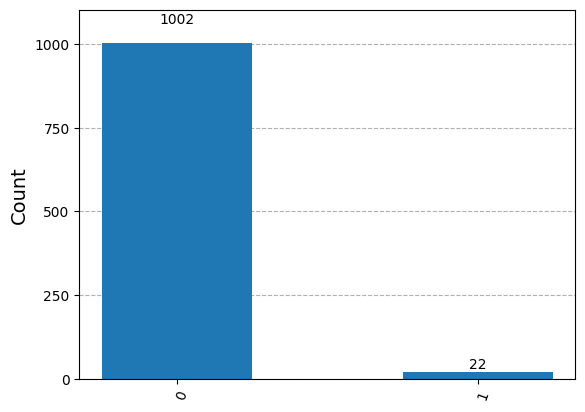

In [10]:
statistics = psi.sample_counts(1024)
plot_histogram(statistics)

# Protocolo Entanglement Swapping

In [11]:
def swapping(bell_state):
    #Se definen 4 qubits
    qubits = QuantumRegister(4, name="q")

    #Se definen 4 canales clásicos
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    bit2 = ClassicalRegister(1, name="bit2")
    bit3 = ClassicalRegister(1, name="bit3")

    #Se construye el objeto circuito
    circuito = QuantumCircuit(qubits, bit0, bit1, bit2, bit3)

    #Se preparan 2 pares de qubits entrelazados en un estado Bell:
    crear_estado_de_bell(circuito, qubits[0], qubits[1], bell_state)
    crear_estado_de_bell(circuito, qubits[2], qubits[3], bell_state)
    circuito.barrier()

    #Medida proyectiva tipo Bell sobre los qúbits B y C
    alice_operaciones(circuito, qubits[1], qubits[2], bit1, bit2)
    circuito.barrier()

    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits[3], bit1, bit2, bell_state)

    #Medidas de los qubits A y D
    alice_operaciones(circuito, qubits[0], qubits[3], bit0, bit3)

    return [circuito, qubits]

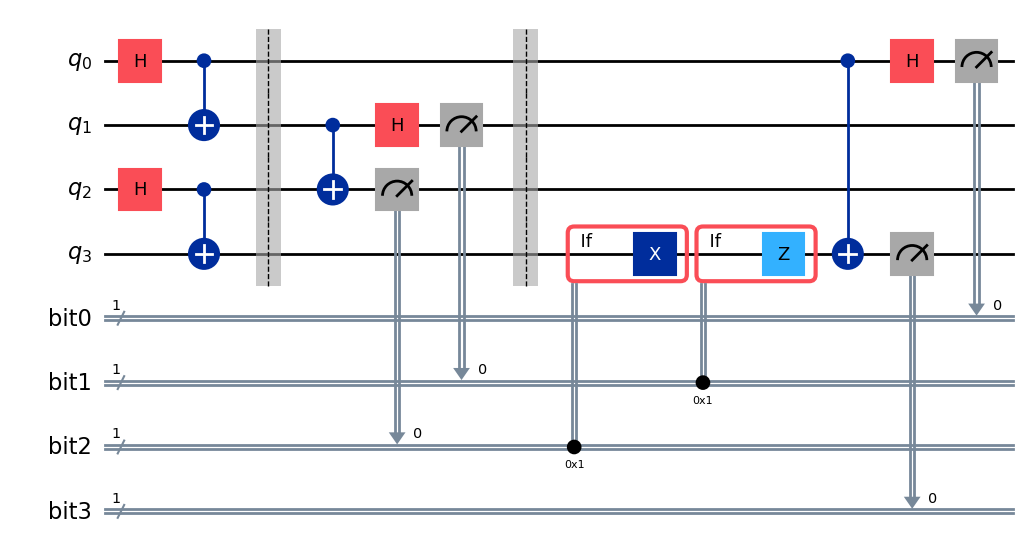

In [12]:
qc_swapping, qubits_swapping = swapping("00")
qc_swapping.draw(output="mpl")

In [13]:
# Con la finalidad de evitar que los qúbits el 100% de las veces estén en un estado clásico, agregamos ruido a las compuertas
import numpy as np
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator

# Importamos el módulo de ruidos de Qiskit Aer
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Se crea un modelo de ruido vacío
noise_model = NoiseModel()

# Se añade error despolarizante a todas las puertas de un solo qubit u1, u2, u3
error = depolarizing_error(0.001, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Se imprime el modelo de ruido
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


In [14]:
# Se simula el circuito de Entanglement Swapping
result_swapping = AerSimulator(noise_model=noise_model).run(qc_swapping).result()
stats_swapping = result_swapping.get_counts()

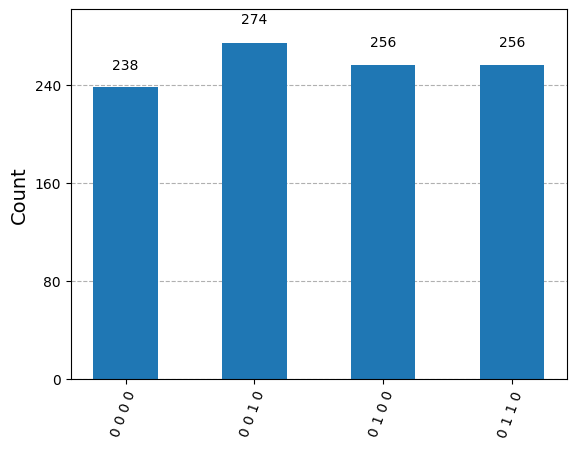

In [15]:
display(plot_histogram(stats_swapping))

Text(0.5, 0, 'Estados Clásicos')

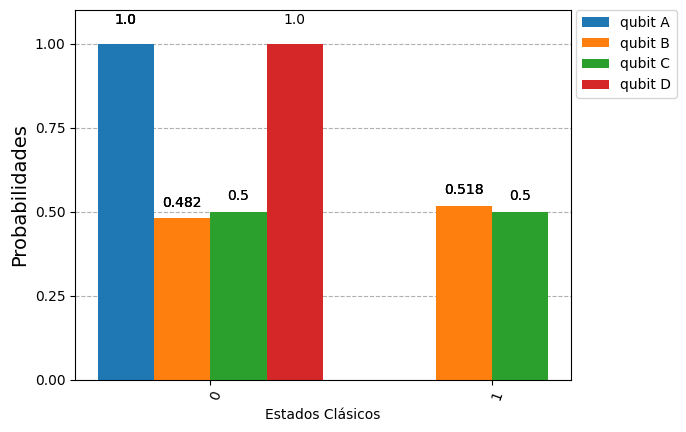

In [16]:
qubit_counts = [marginal_counts(stats_swapping, [bit]) for bit in range(4)]
grafica = plt.subplot()
legendas = ["qubit A","qubit B","qubit C","qubit D"]
plot_distribution(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Probabilidades')
grafica.set_xlabel('Estados Clásicos')

# Entanglement Swapping con estados Mezcla tipo Werner

In [17]:
# Función que genera los 4 estados de Bell
def crear_estados_werner(circuito, qubits, parameter):
    #Define el generador de números aleatorios con una ponderación de w
    circuito.ry(parameter, qubits[0])
    circuito.cx(qubits[0], qubits[2])

    #Genera estado máximamente mezclado
    circuito.h(qubits[0])

    circuito.x(qubits[2])
    circuito.ch(qubits[2], qubits[1])
    circuito.ccx(qubits[0],qubits[2],qubits[3])
    circuito.ccx(qubits[1],qubits[2],qubits[4])

    #Genera estado entrelazado
    circuito.x(qubits[2])
    circuito.cx(qubits[2],qubits[1])
    circuito.ccx(qubits[0],qubits[2],qubits[1])
    circuito.x(qubits[2])

In [18]:
def swapping_werner(w, bell_state="11"):
    #Conversión de w a theta
    theta = 2*np.arcsin(w)

    #Se definen 10 qubits
    qubits = QuantumRegister(10, name="q")

    #Se definen 4 canales clásicos
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    bit2 = ClassicalRegister(1, name="bit2")
    bit3 = ClassicalRegister(1, name="bit3")

    #Se construye el objeto circuito
    circuito = QuantumCircuit(qubits, bit0, bit1, bit2, bit3)

    #Inicializamos par en estados Werner del qubit[0] hasta el qubit[4]
    #Con parámetro de mezcla theta[0]
    crear_estados_werner(circuito, [0,1,2,3,4], theta[0])

    #Inicializamos par en estados Werner del qubit[5] hasta el qubit[9]
    #Con parámetro de mezcla theta[1]
    crear_estados_werner(circuito, [5,6,7,8,9], theta[1])

    circuito.barrier()

    #Medida proyectiva tipo Bell sobre los qúbits 1 y 5
    alice_operaciones(circuito, qubits[1], qubits[5], bit1, bit2)
    circuito.barrier()

    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits[6], bit1, bit2, bell_state)

    #Medidas de los qubits 0 y 6
    alice_operaciones(circuito, qubits[0], qubits[6], bit0, bit3)

    return [circuito, qubits]

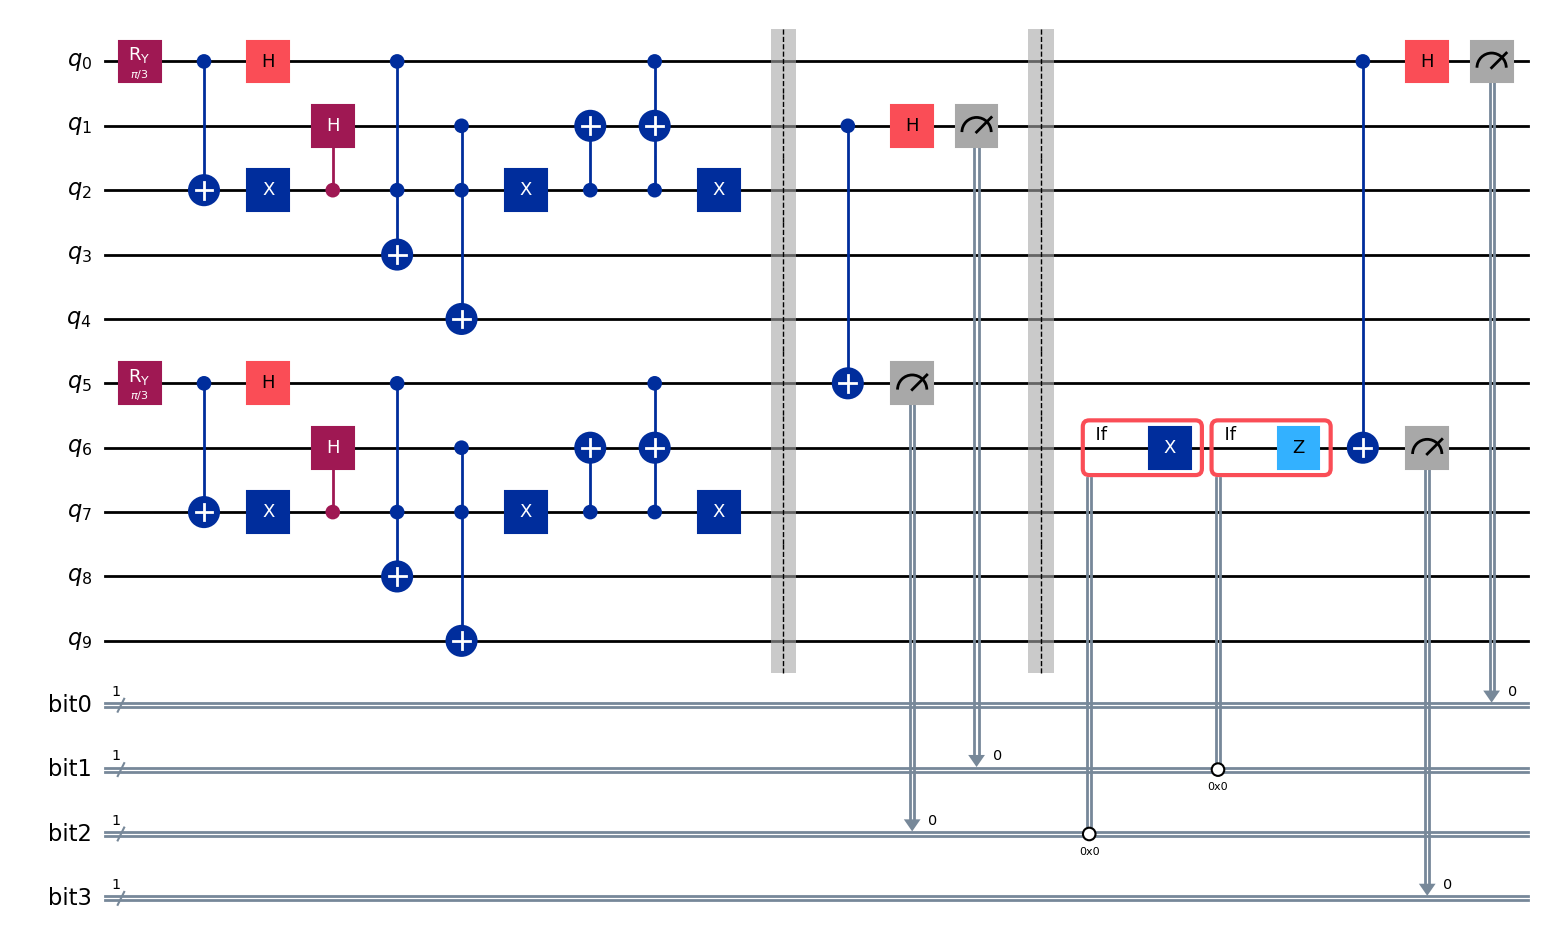

In [19]:
qc_werner, qubits_werner = swapping_werner([0.5,0.5], "11")
qc_werner.draw(output="mpl")

In [20]:
qc = transpile(qc_werner, AerSimulator())
sim_werner = AerSimulator().run(qc).result()
counts_werner = sim_werner.get_counts()

Text(0.5, 0, 'Classical State')

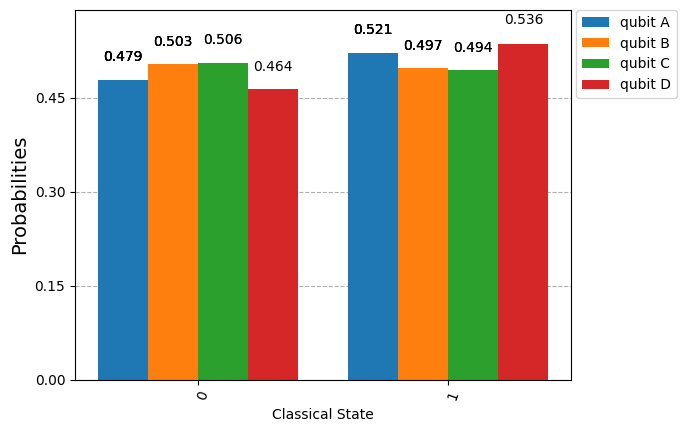

In [21]:
qubit_counts_w = [marginal_counts(counts_werner, [bit]) for bit in range(4)]
grafica_w = plt.subplot()
legendas_w = ["qubit A","qubit B","qubit C","qubit D"]
plot_distribution(qubit_counts_w, ax=grafica_w, legend=legendas_w)
grafica_w.set_ylabel('Probabilities')
grafica_w.set_xlabel('Classical State')

In [20]:
image = qc_werner.draw(output="mpl")

In [21]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Convierte la imagen a un objeto de bytes
buf = BytesIO()
image.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
im = Image.open(buf)

# Convierte la imagen a formato RGB
im = im.convert('RGB')

# Guarda la imagen en formato PDF
im.save('circuito2.pdf', 'PDF', resolution=100.0)